In [1]:
# Install torch and torchvision using pip
# pip install torch torchvision --index-url https://download.pytorch.org/whl/cu118

# Import and load data

In [55]:
from PIL import Image
import numpy as np
import pandas as pd
import os
import torch
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from glob import glob
from torch import nn, optim
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

In [56]:
# Define a function to open an image from a given path
def open_image(image_path, numpy_format=False):
    # Open the image using PIL library
    image = Image.open(image_path)
    # If numpy_format is True, convert the image to numpy array
    return image if not numpy_format else np.array(image)

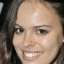

In [57]:
open_image('/home/glab/Desktop/kaggle/train_64/train_64/imgs/000000_64.jpg',
           numpy_format=False)

# Labels overview

In [58]:
# WARNING : PATH TO EDIT

# Path to the images folder
root = "/home/glab/Desktop/kaggle/train_64/train_64/imgs/"
# Path to the labels file
labels = pd.read_csv("/home/glab/Desktop/kaggle/train_df_challenge.csv")
# Path to the test images folder
root_kaggle = "/home/glab/Desktop/kaggle/test_64/test_64/imgs/"

In [59]:
# Add a column to the labels dataframe with the index
labels['index'] = labels.index
labels['path'] = labels['index'].apply(lambda index: f'{index:06}_64.jpg')
del labels['index']
labels.head()

,Female,Young,Attractive,Smiling,Oval_Face,Wavy_Hair,path
0,1.0,1.0,1.0,1.0,0.0,1.0,000000_64.jpg
1,0.0,1.0,0.0,1.0,1.0,0.0,000001_64.jpg
2,1.0,0.0,1.0,1.0,0.0,0.0,000002_64.jpg
3,1.0,1.0,1.0,1.0,1.0,0.0,000003_64.jpg
4,0.0,1.0,0.0,0.0,0.0,0.0,000004_64.jpg


In [60]:
# Check the first path
labels["path"].iloc[0]

'000000_64.jpg'

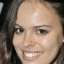

In [61]:
open_image(root + labels["path"].iloc[0], numpy_format=False)

In [62]:
labels.iloc[0, :5].to_numpy().astype("float")

array([1., 1., 1., 1., 0.])

In [63]:
# labels.to_csv("../labels.csv", index=False)

# Resampling Young/Attr

In [38]:
from sklearn.model_selection import train_test_split

labels_train, labels_test = train_test_split(labels, test_size=0.2)

In [11]:
# Query for estimate attr by gender
labels.query("Young == 0.0 and Attractive == 1.0")

,Female,Young,Attractive,Smiling,Oval_Face,Wavy_Hair,path
2,1.0,0.0,1.0,1.0,0.0,0.0,000002_64.jpg
16,0.0,0.0,1.0,1.0,1.0,0.0,000016_64.jpg
26,1.0,0.0,1.0,1.0,1.0,1.0,000026_64.jpg
69,0.0,0.0,1.0,1.0,0.0,0.0,000069_64.jpg
104,1.0,0.0,1.0,1.0,0.0,1.0,000104_64.jpg
...,...,...,...,...,...,...,...
162679,0.0,0.0,1.0,1.0,0.0,0.0,162679_64.jpg
162684,0.0,0.0,1.0,1.0,0.0,0.0,162684_64.jpg
162706,1.0,0.0,1.0,1.0,1.0,0.0,162706_64.jpg
162752,1.0,0.0,1.0,1.0,0.0,0.0,162752_64.jpg


In [12]:
# Female = 0 and Attractive = 1 : 19014
# Female = 1 and Attractive = 1 : 64589

# Young = 0 and Attractive = 1 : 5364
# Young = 1 and Attractive = 1 : 78239

In [13]:
B1 = labels_train[(labels_train["Young"] == 1) & (labels_train["Attractive"] == 1)]
B2 = labels_train[(labels_train["Young"] == 0) & (labels_train["Attractive"] == 1)]
B3 = labels_train[(labels_train["Young"] == 1) & (labels_train["Attractive"] == 0)]
B4 = labels_train[(labels_train["Young"] == 0) & (labels_train["Attractive"] == 0)]

print("B1:", B1.shape)
print("B2:", B2.shape)
print("B3:", B3.shape)
print("B4:", B4.shape)

B1: (62437, 7)
B2: (4255, 7)
B3: (38926, 7)
B4: (24598, 7)


In [14]:
diff = len(B1)-len(B2)
oversampled_B2 = B2.sample(n=diff, replace=True, random_state=42)
B2_surech = pd.concat([B2, oversampled_B2], ignore_index=True)

print("B1:", B1.shape)
print("B2:", B2_surech.shape)

B1: (62437, 7)
B2: (62437, 7)


In [15]:
diff = len(B3)-len(B4)
oversampled_B4 = B4.sample(n=diff, replace=True, random_state=42)
B4_surech = pd.concat([B4, oversampled_B4], ignore_index=True)

print("B3:", B3.shape)
print("B4:", B4_surech.shape)

B3: (38926, 7)
B4: (38926, 7)


In [16]:
B2_surech.path.value_counts()

path
044530_64.jpg    29
030385_64.jpg    28
006440_64.jpg    28
033828_64.jpg    28
072062_64.jpg    28
                 ..
103946_64.jpg     5
161583_64.jpg     5
088518_64.jpg     5
161961_64.jpg     5
002117_64.jpg     5
Name: count, Length: 4255, dtype: int64

In [17]:
dataframes = [B1, B2_surech, B3, B4_surech]

labels_di = pd.concat(dataframes, ignore_index=True)
labels_di.shape

(202726, 7)

In [18]:
labels_di = labels_di.sample(frac=1).reset_index(drop=True)

# Resampling Female/Attr

In [19]:
# Query for estimate attr by gender
labels.query("Female == 1.0 and Attractive == 0.0")

,Female,Young,Attractive,Smiling,Oval_Face,Wavy_Hair,path
13,1.0,1.0,0.0,0.0,0.0,0.0,000013_64.jpg
18,1.0,0.0,0.0,0.0,0.0,1.0,000018_64.jpg
19,1.0,1.0,0.0,1.0,0.0,0.0,000019_64.jpg
23,1.0,1.0,0.0,0.0,0.0,0.0,000023_64.jpg
28,1.0,1.0,0.0,0.0,0.0,0.0,000028_64.jpg
...,...,...,...,...,...,...,...
162753,1.0,1.0,0.0,0.0,0.0,0.0,162753_64.jpg
162756,1.0,1.0,0.0,0.0,0.0,0.0,162756_64.jpg
162757,1.0,0.0,0.0,0.0,0.0,1.0,162757_64.jpg
162758,1.0,0.0,0.0,1.0,0.0,1.0,162758_64.jpg


In [20]:
# Female = 1 and Attractive = 1 : 64589
# Female = 0 and Attractive = 1 : 19014
# x3.397

In [21]:
# Query for estimate attr by gender
labels_di.query("Female == 1.0 and Attractive == 0.0")

,Female,Young,Attractive,Smiling,Oval_Face,Wavy_Hair,path
0,1.0,0.0,0.0,1.0,0.0,0.0,151255_64.jpg
3,1.0,0.0,0.0,1.0,0.0,1.0,127003_64.jpg
7,1.0,1.0,0.0,0.0,1.0,0.0,067045_64.jpg
11,1.0,0.0,0.0,1.0,1.0,1.0,107007_64.jpg
21,1.0,1.0,0.0,0.0,0.0,0.0,108829_64.jpg
...,...,...,...,...,...,...,...
202670,1.0,0.0,0.0,0.0,0.0,1.0,110775_64.jpg
202684,1.0,0.0,0.0,0.0,1.0,1.0,149154_64.jpg
202685,1.0,1.0,0.0,0.0,0.0,0.0,053129_64.jpg
202699,1.0,1.0,0.0,1.0,0.0,1.0,026284_64.jpg


In [22]:
# Female = 1 and Attractive = 1 : 126246
# Female = 0 and Attractive = 1 : 48163
# x2.621

In [23]:
B1 = labels_di[(labels_di["Female"] == 1) & (labels_di["Attractive"] == 1)]
B2 = labels_di[(labels_di["Female"] == 0) & (labels_di["Attractive"] == 1)]
B3 = labels_di[(labels_di["Female"] == 1) & (labels_di["Attractive"] == 0)]
B4 = labels_di[(labels_di["Female"] == 0) & (labels_di["Attractive"] == 0)]

print("B1:", B1.shape)
print("B2:", B2.shape)
print("B3:", B3.shape)
print("B4:", B4.shape)

B1: (91091, 7)
B2: (33783, 7)
B3: (27488, 7)
B4: (50364, 7)


In [24]:
diff = len(B1)-len(B2)
oversampled_B2 = B2.sample(n=diff, replace=True, random_state=42)
B2_surech = pd.concat([B2, oversampled_B2], ignore_index=True)

print("B1:", B1.shape)
print("B2:", B2_surech.shape)

B1: (91091, 7)
B2: (91091, 7)


In [25]:
diff = len(B4)-len(B3)
oversampled_B3 = B3.sample(n=diff, replace=True, random_state=42)
B3_surech = pd.concat([B3, oversampled_B3], ignore_index=True)

print("B3:", B3_surech.shape)
print("B4:", B4.shape)

B3: (50364, 7)
B4: (50364, 7)


In [26]:
dataframes = [B1, B2_surech, B3_surech, B4]

labels_di = pd.concat(dataframes, ignore_index=True)
labels_di.shape

(282910, 7)

In [27]:
labels_di = labels_di.sample(frac=1).reset_index(drop=True)

# Split and DataLoader

In [64]:
# Define a custom dataset class
class CustomDataset(Dataset):
    def __init__(self, labels, root):
        self.img_labels = labels
        self.root = root

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, index):
        img_path = self.root + self.img_labels['path'].iloc[index]
        image = open_image(img_path, numpy_format=True)
        label = self.img_labels.iloc[index, :6].to_numpy().astype('float')
        # Convert image and label to torch tensors
        image = torch.from_numpy(image)
        label = torch.from_numpy(label).float()
        # Pytorch works with C x H x W format
        image = image.permute(2, 0, 1)
        # Normalize the image
        image = image/255

        return image, label

In [65]:
# Define the dataset
dataset = CustomDataset(labels, root)

# Split the dataset into train and test
generator = torch.Generator().manual_seed(42)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_size, test_size], generator=generator)

In [66]:
# Define the dataloader for train and test datasets
batch_size = 512
train_dataloader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False)

# DataLoader for DI correction

In [31]:
# Define the dataset
dataset_di = CustomDataset(labels_di, root)
dataset_test = CustomDataset(labels_test, root)

# Split the dataset into train and test
# generator = torch.Generator().manual_seed(42)
# train_size_di = int(0.8 * len(dataset_di))
# test_size_di = len(dataset_di) - train_size_di
# train_dataset_di, test_dataset_di = torch.utils.data.random_split(
#     dataset_di, [train_size_di, test_size_di], generator=generator)

In [32]:
# # Define the dataloader for train and test datasets
# batch_size = 512
# train_dataloader_di = DataLoader(
#     train_dataset_di, batch_size=batch_size, shuffle=True)
# test_dataloader_di = DataLoader(
#     test_dataset_di, batch_size=batch_size, shuffle=False)

In [33]:
# Define the dataloader for train and test datasets
batch_size = 512
train_dataloader_di = DataLoader(
    dataset_di, batch_size=batch_size, shuffle=True)
test_dataloader_di = DataLoader(
    dataset_test, batch_size=batch_size, shuffle=False)

# Metric and score function

In [14]:
def accuracy(y_pred, y_true):
    y_pred = (y_pred > 0.5).float()
    return (y_pred == y_true).float().mean() * 100

In [15]:
def disparate_impact_fem(prediction, labels):
    numerator = (prediction[:, 2] == 1) & (labels[:, 0] == 1)
    denominator = (prediction[:, 2] == 1) & (labels[:, 0] == 0)
    return numerator.sum() / (denominator.sum() + 1e-8)

In [16]:
def disparate_impact_youn(prediction, labels):
    numerator = (prediction[:, 2] == 1) & (labels[:, 1] == 1)
    denominator = (prediction[:, 2] == 1) & (labels[:, 1] == 0)
    return numerator.sum() / (denominator.sum() + 1e-8)

In [17]:
def custom_score(prediction, labels):

    accuracy_attr = accuracy(prediction[:, 2], labels[:, 2])

    DI_attr_fem = disparate_impact_fem(prediction, labels)
    DI_attr_youn = disparate_impact_youn(prediction, labels)

    accuracy_fem = accuracy(prediction[:, 0], labels[:, 0])
    accuracy_youn = accuracy(prediction[:, 1], labels[:, 1])
    accuracy_smil = accuracy(prediction[:, 3], labels[:, 3])
    accuracy_oval = accuracy(prediction[:, 4], labels[:, 4])
    accuracy_wavy = accuracy(prediction[:, 5], labels[:, 5])
    accuracy_label = (accuracy_fem + accuracy_youn + accuracy_smil + accuracy_oval + accuracy_wavy) / 5

    return 0.3 * (accuracy_attr-5*(DI_attr_youn-1)-2*(DI_attr_fem-1)) + 0.5 * accuracy_label

# Models

In [42]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.conv_bn_relu_stack = nn.Sequential(
            nn.Conv2d(3, 32, 3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, 3),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )

        self.linear_relu_stack = nn.Sequential(
            nn.Linear(18432, 64), nn.ReLU(), nn.Linear(64, 6)
        )

    def forward(self, x):
        x = self.conv_bn_relu_stack(x)
        x = self.flatten(x)
        x = self.linear_relu_stack(x)
        return x

In [78]:
import torch.nn as nn
import torch.nn.functional as F

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        ## encoder layers ##
        self.conv1 = nn.Conv2d(3, 16, 3,padding=1)
        self.conv2 = nn.Conv2d(16, 3, 3,padding=1)
        self.maxPool = nn.MaxPool2d(2,2)
        
        ## decoder layers ##
        ## a kernel of 2 and a stride of 2 will increase the spatial dims by 2
        self.conv3 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv4 = nn.Conv2d(16, 1, 3, padding=1)

    def forward(self, x):
        ## encode ##
        x = self.maxPool(F.relu(self.conv1(x)))
        x = self.maxPool(F.relu(self.conv2(x)))
        
        ## decode ##
        x = F.interpolate(F.relu(self.conv3(x)), scale_factor=2, mode='nearest')
        x = (F.relu(self.conv3(x)))
        x = F.interpolate(F.relu(self.conv4(x)), scale_factor=2, mode='nearest')
        x = (F.sigmoid(self.conv4(x)))
        
        ## apply ReLu to all hidden layers *except for the output layer
        ## apply a sigmoid to the output layer
        
                
        return x

In [79]:
# to debug quickly
model = Autoencoder()
model.to(device)

Autoencoder(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxPool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(16, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

# Iteration

In [69]:
# Check if GPU is available
device = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(device)
print(device)

cuda


In [70]:
# Choose the model to use
model = Autoencoder()
# psh model on cuda
model.to(device)

Autoencoder(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxPool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(16, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [71]:
# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

In [72]:
# Loss function
sigmoid = nn.Sigmoid()
bce = nn.BCELoss(reduction="mean") # cnn
mse = nn.MSELoss(reduction="mean") # autoencoders

In [80]:
# Train the model
epochs = 1
# Initialization
train_losses_dict = {}
test_losses_dict = {}
scores = []

for epoch in range(epochs):
    # List to store losses
    train_losses = []
    test_losses = []
    for phase in ['train', 'test']:
        dl = train_dataloader if phase == 'train' else test_dataloader
        # Bar to display progress
        for batch in (bar := tqdm(iter(dl))):
            ims, gt = batch
            # Move the images and gt to the device (like the model)
            ims = ims.to(device)
            gt = gt.to(device)

            # output = sigmoid(model(ims))
            output = model(ims)
            loss = mse(output, ims)
            # prediction = (output > 0.5).float()
            # score = custom_score(prediction, gt)
            # scores.append(score.item())

            if phase == 'train':
                train_losses.append(loss.item())
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
                bar.set_description(
                    # f"Train {epoch+1} loss: {np.mean(train_losses).item():.4f}, Train score: {score.item():.4f}")
                    f"Train {epoch+1} loss: {np.mean(train_losses).item():.4f}")
                scheduler.step()
            else:
                test_losses.append(loss.item())
                bar.set_description(
                    # f"Test {epoch+1} loss: {np.mean(test_losses).item():.4f}, Test score: {score.item():.4f}")
                    f"Test {epoch+1} loss: {np.mean(test_losses).item():.4f}")

        if phase == 'train':
            train_losses_dict[epoch+1] = np.mean(train_losses).item()

  0%|          | 0/255 [00:00<?, ?it/s]


RuntimeError: Given groups=1, weight of size [16, 3, 3, 3], expected input[512, 16, 32, 32] to have 3 channels, but got 16 channels instead

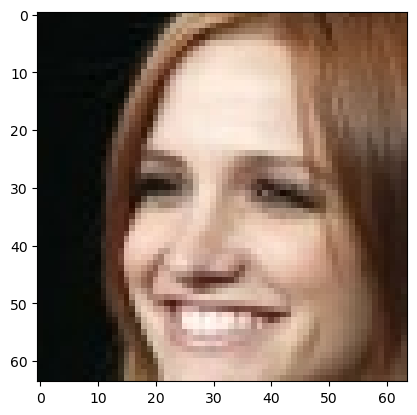

In [50]:
plt.imshow(ims[0].permute(1, 2, 0).cpu().detach().numpy())

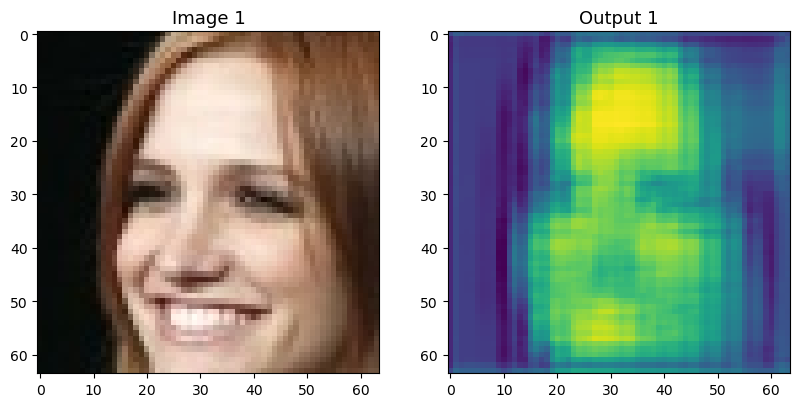

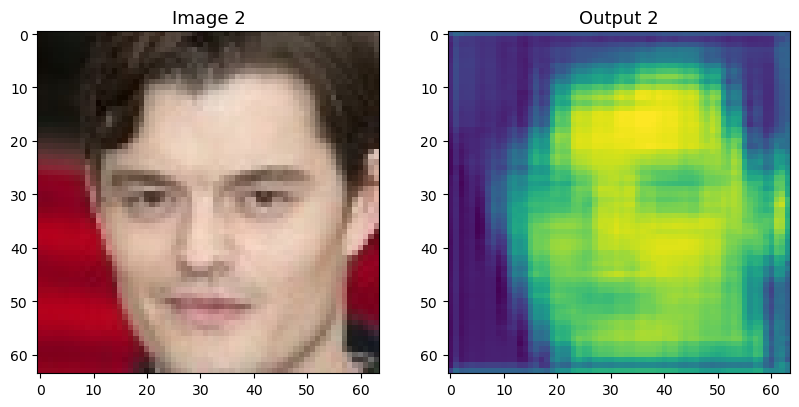

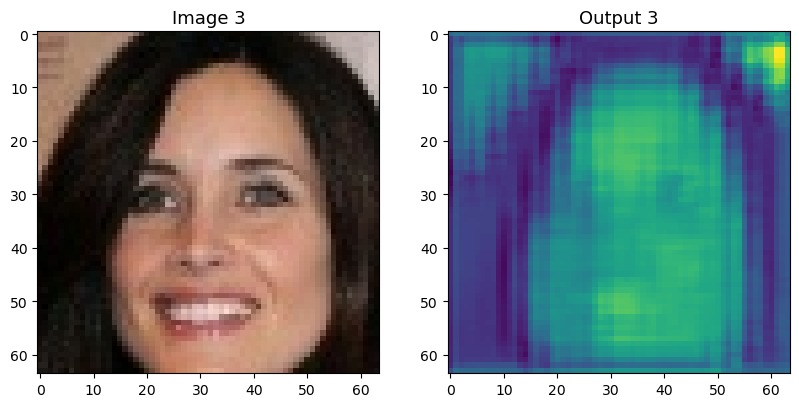

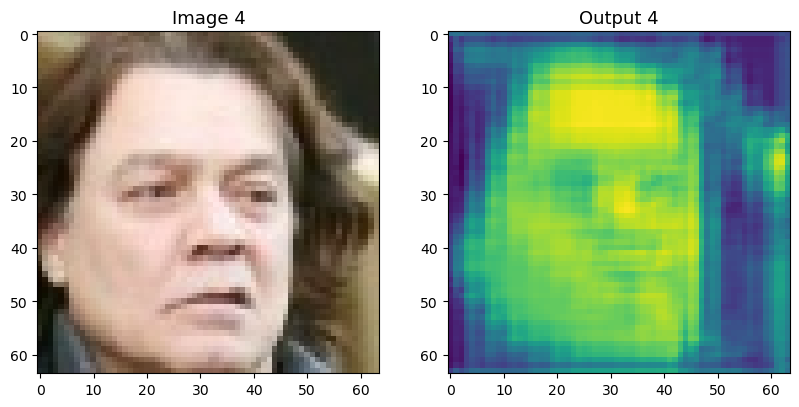

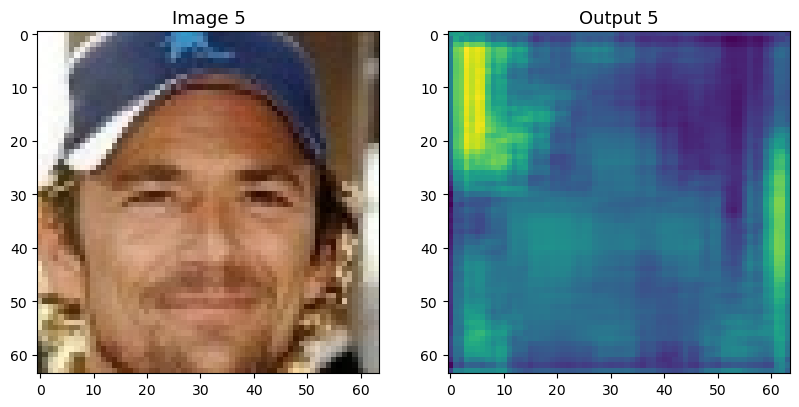

In [54]:
for i in range(5):
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    titleI = 'Image ' + str(i+1)
    plt.title(titleI, color = 'black', fontsize = 13)
    plt.imshow(ims[i].cpu().detach().permute(1, 2, 0))
    plt.subplot(1,3,2)
    titleO = 'Output ' + str(i+1)
    plt.title(titleO, color = 'black', fontsize = 13)
    plt.imshow(output[i].cpu().detach().permute(1, 2, 0))

## Empty GPU cache

In [126]:
# empty nvidia
torch.cuda.empty_cache()

# Save model

In [ ]:
# Save the model with correct name
name = 'cnn'
torch.save(model.state_dict(), '../models/' + model + '.pth')

# Graph

In [ ]:
# scores rolling mean
scores_roll = pd.Series(scores)
scores_roll = scores_roll.rolling(10).mean()
plt.plot(scores_roll)

In [ ]:
train_losses_dict

# Export for submission¶

In [ ]:
# Define a custom dataset class
class KaggleDataset(Dataset):
    def __init__(self, root_kaggle):
        self.root_kaggle = root_kaggle
        self.files_list = sorted(glob(self.root_kaggle + "*.jpg"))

    def __len__(self):
        return len(self.files_list)

    def __getitem__(self, index):
        img_path = self.files_list[index]
        image = open_image(img_path, numpy_format=True)
        # Convert image and label to torch tensors
        image = torch.from_numpy(image)
        # Pytorch works with C x H x W format
        image = image.permute(2, 0, 1)
        # Normalize the image
        image = image/255

        return image, img_path.split("/")[-1]

In [ ]:
# Define the dataset
kaggle_dataset = KaggleDataset(root_kaggle)

In [ ]:
# Define the dataloader for train and test datasets
batch_size = 256
kaggle_dataloader = DataLoader(
    kaggle_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
predictions_list = []
paths_list = []
for batch in (bar:= tqdm(iter(kaggle_dataloader))):
    images, paths = batch
    # Move the images and gt to the device (like the model)
    with torch.no_grad():
        images = images.to(device)
        outputs = sigmoid(model(images))
    # Append the prediction to the a list
    predictions = list((outputs > 0.5).detach().cpu().numpy().astype(int))
    predictions_list.extend(predictions)
    paths_list.extend(paths)

100%|██████████| 78/78 [00:05<00:00, 14.91it/s]


In [ ]:
col_names = ['ID', 'Female', 'Young', 'Attractive', 'Smiling', 'Oval_Face', 'Wavy_Hair']
df = pd.DataFrame({'ID': paths_list})

for i, col_name in enumerate(col_names[1:]):
    df[col_name] = [p[i] for p in predictions_list]

print(df.head())
# +1 for version
df.to_csv('../subs/submission01.csv', index=False)

              ID  Female  Young  Attractive  Smiling  Oval_Face  Wavy_Hair
0  000000_64.jpg       0      1           1        0          0          0
1  000001_64.jpg       0      1           1        0          1          1
2  000002_64.jpg       1      1           1        1          1          1
3  000003_64.jpg       1      1           1        0          1          0
4  000004_64.jpg       0      0           0        1          1          0


In [35]:
# 19962 is the correct value for submit
len(df)

NameError: name 'df' is not defined